In [2]:
import pandas as pd
import random
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time
import numpy as np
from fairlearn.datasets import fetch_acs_income
import shap

from scipy.spatial.distance import cosine, euclidean
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import uniform, randint
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, ParameterSampler, train_test_split, StratifiedShuffleSplit
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.utils import class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, classification_report,  roc_auc_score

import tensorflow
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout
from keras.optimizers import Adam
from xgboost import XGBRegressor, XGBClassifier #continuous values?


## Binary classification

In [3]:
data = fetch_acs_income()
# convert to df
df = pd.DataFrame(data.data, columns=data.feature_names)
df['target'] = data.target
 # I'm not sure what this feature even is cause I can't  find anything about it in the documenation so I'm leaving it oout for now
df = df.drop(columns=['ST'], errors='ignore')

print(df.head())

   AGEP  COW  SCHL  MAR    OCCP  POBP  RELP  WKHP  SEX  RAC1P   target
0  18.0  1.0  18.0  5.0  4720.0  13.0  17.0  21.0  2.0    2.0   1600.0
1  53.0  5.0  17.0  5.0  3605.0  18.0  16.0  40.0  1.0    1.0  10000.0
2  41.0  1.0  16.0  5.0  7330.0   1.0  17.0  40.0  1.0    1.0  24000.0
3  18.0  6.0  18.0  5.0  2722.0   1.0  17.0   2.0  2.0    1.0    180.0
4  21.0  5.0  19.0  5.0  3870.0  12.0  17.0  50.0  1.0    1.0  29000.0


### Data Analysis

In [ ]:
df.isna().sum()

AGEP      0
COW       0
SCHL      0
MAR       0
OCCP      0
POBP      0
RELP      0
WKHP      0
SEX       0
RAC1P     0
target    0
dtype: int64

In [ ]:
df['OCCP'].value_counts().sort_index()


OCCP
10.0      14296
20.0      10186
40.0        563
51.0       5548
52.0       4601
          ...  
9760.0      803
9800.0      413
9810.0      794
9825.0     1993
9830.0     2504
Name: count, Length: 529, dtype: int64

In [4]:
numeric_cols = ['AGEP', 'WKHP']
categorical_cols = ['COW', 'SCHL', 'MAR', 'OCCP', 'POBP', 'RELP', 'SEX',  'RAC1P'] 

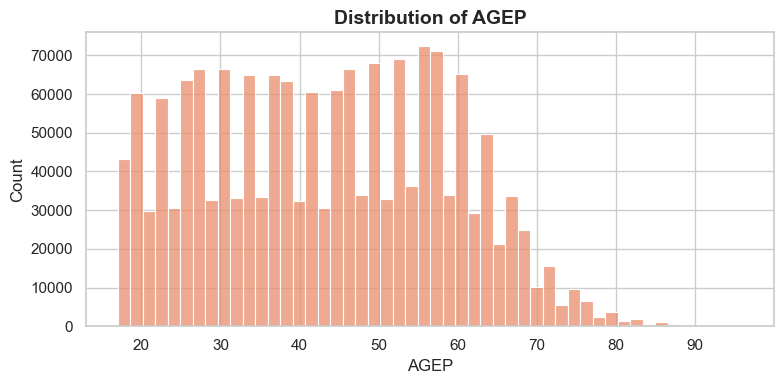

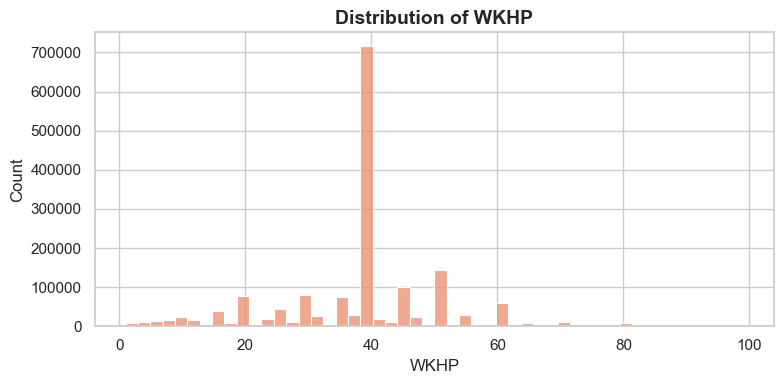

In [4]:

sns.set_theme(style="whitegrid", palette="flare")

for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=50, kde=False, color=sns.color_palette("flare")[0])
    plt.title(f'Distribution of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()


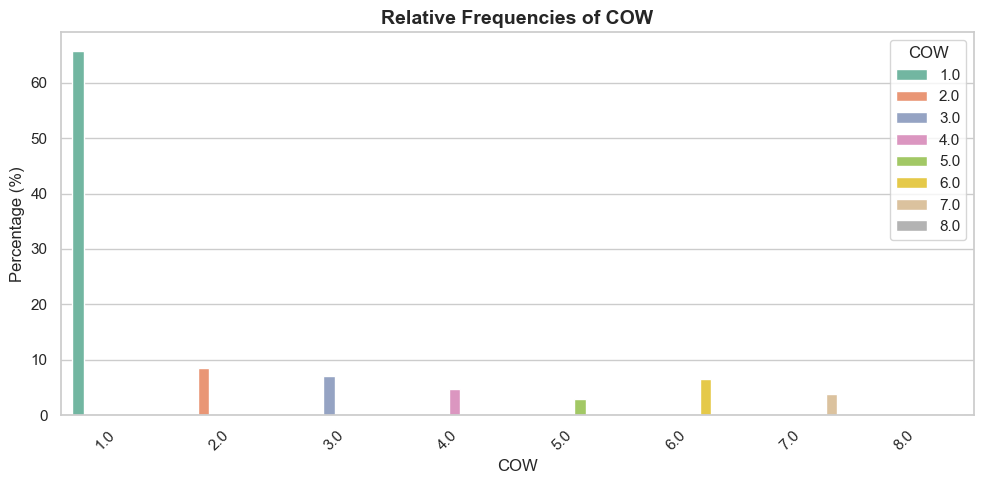

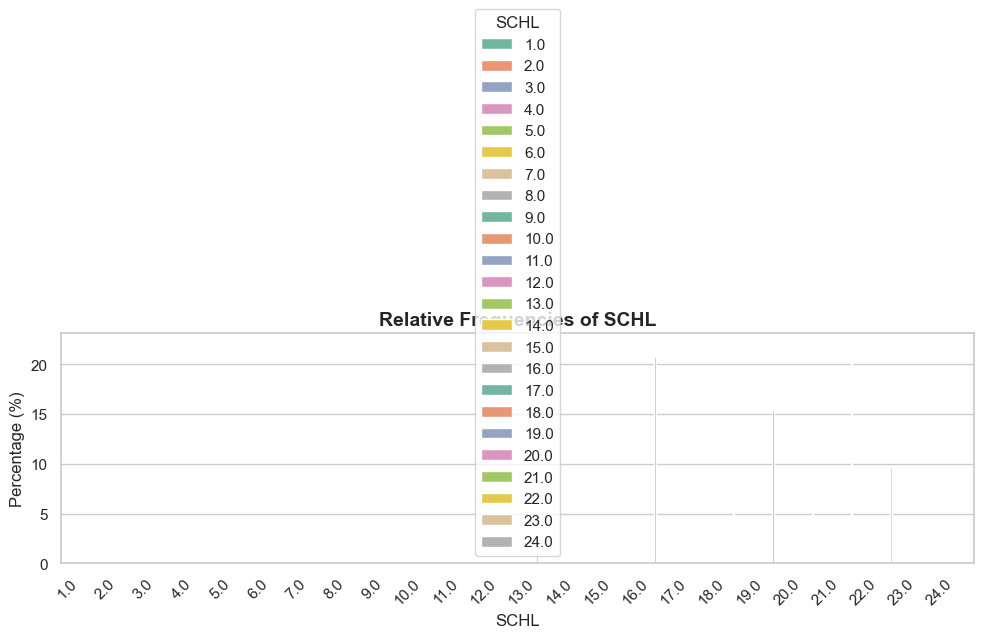

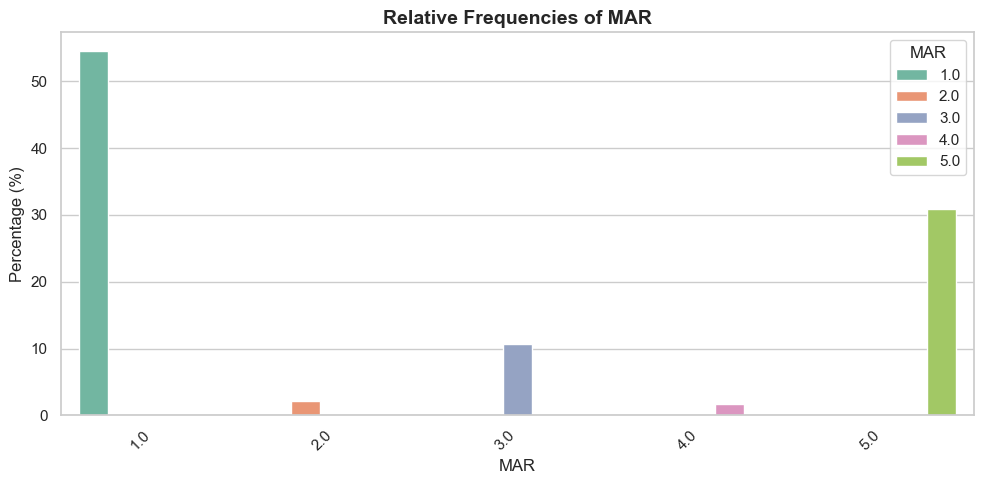

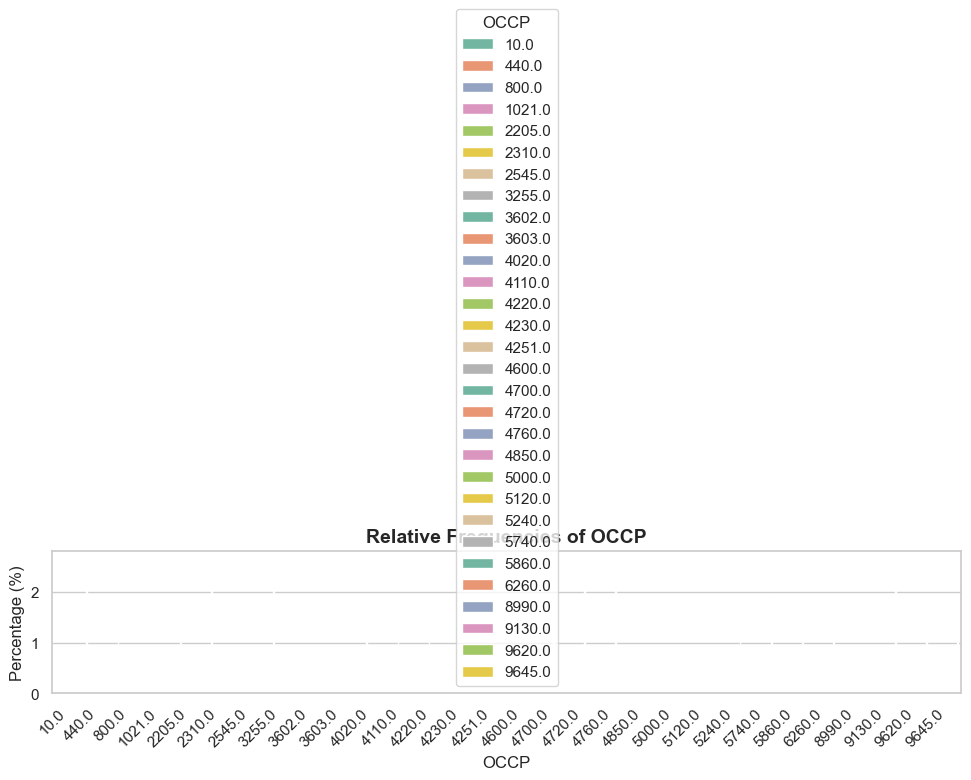

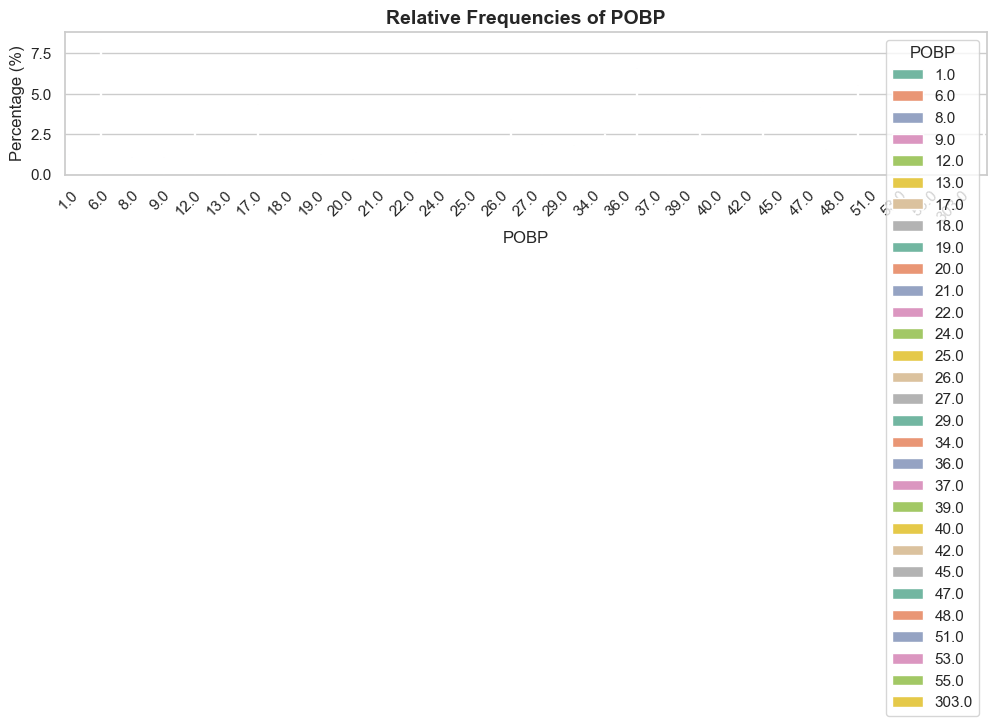

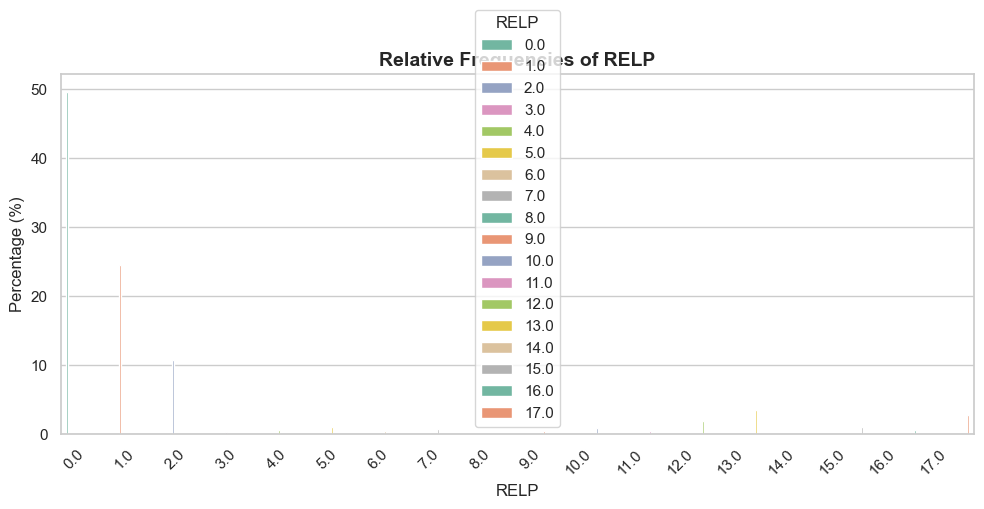

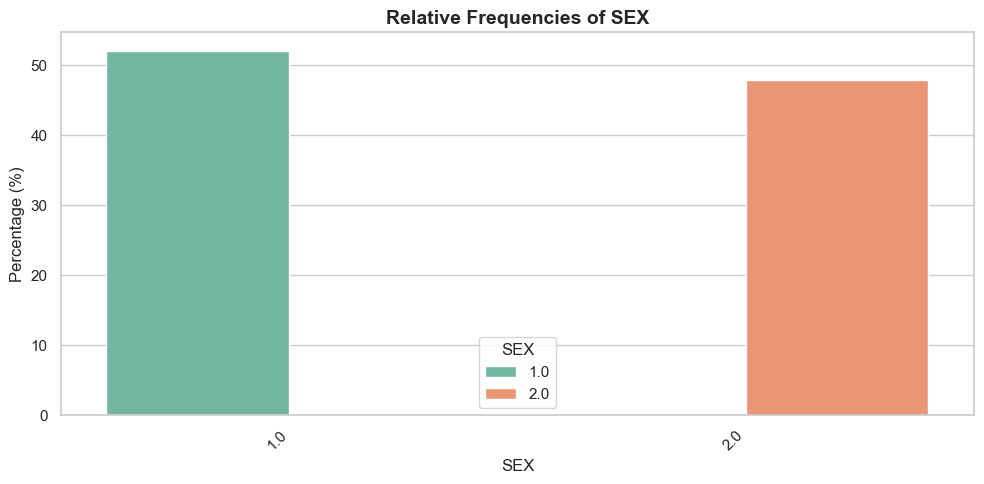

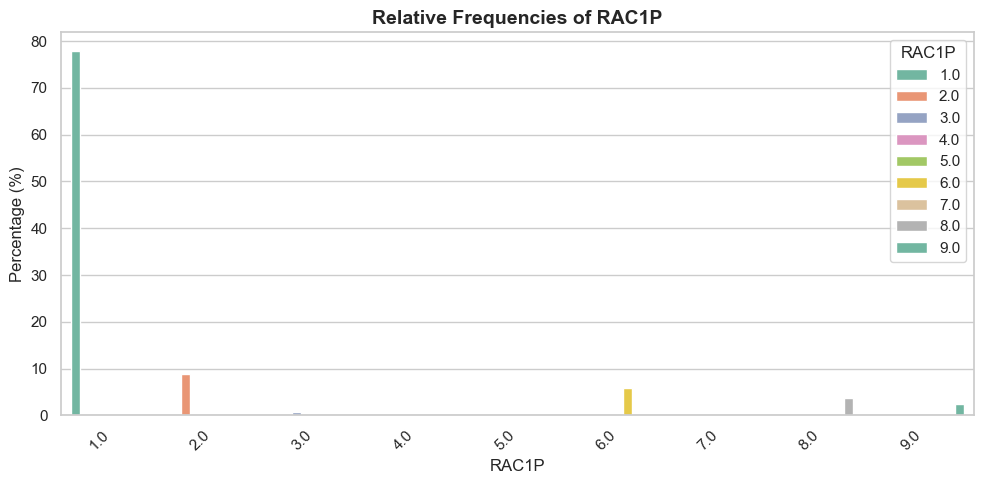

In [6]:
sns.set_theme(style="whitegrid", palette="Set2")

limit_top_n = 30
columns_to_limit = ['OCCP', 'POBP'] 


for col in categorical_cols:
    plt.figure(figsize=(10, 5))

    # value counts normalized
    value_counts = df[col].value_counts(normalize=True) * 100
    
    if col in columns_to_limit:
        value_counts = value_counts.head(limit_top_n)

    plot_df = value_counts.reset_index()
    plot_df.columns = [col, 'percentage']

    sns.barplot(data=plot_df, x=col, y='percentage', hue=col, palette="Set2")
    
    plt.title(f'Relative Frequencies of {col}', fontsize=14, weight='bold')
    plt.xlabel(col)
    plt.ylabel('Percentage (%)')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

### Pre-processing

In [ ]:
# potential approaches #
# Age clustering
# removing certain subgroups from OCCP, POBP

### Creating thresholds and splitting datasets

In [5]:

def preprocess_income_data(df, threshold):
    df_copy = df.copy()
    df_copy['binary_target'] = (df_copy['target'] >= threshold).astype(int)
    X = df_copy.drop(columns=['target', 'binary_target'], errors='ignore')
    y = df_copy['binary_target']
    return X, y


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=True), categorical_cols)
    ],
    remainder='passthrough' 
)

threshold = 50000
X, y = preprocess_income_data(df, threshold)

# tempsplit: train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# final split: validation (15%) and test (15%) from temp
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

preprocessor.fit(X_train)

X_train_enc = preprocessor.transform(X_train)
X_val_enc   = preprocessor.transform(X_val)
X_test_enc  = preprocessor.transform(X_test)


In [6]:
y_train = y_train.to_numpy() if hasattr(y_train, "to_numpy") else y_train
y_val = y_val.to_numpy() if hasattr(y_val, "to_numpy") else y_val

In [5]:
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

all_feature_names = list(ohe_feature_names) + numeric_cols

### Linear baseline model for performance comparison 
### **DO NOT RUN takes ages**

In [9]:
logreg = LogisticRegression(solver= 'saga', class_weight='balanced', max_iter=2500)
logreg.fit(X_train_enc, y_train)
y_pred_logreg = logreg.predict(X_test_enc)
print(classification_report(y_test, y_pred_logreg))


              precision    recall  f1-score   support

           0       0.87      0.79      0.83    151206
           1       0.72      0.82      0.77     98469

    accuracy                           0.80    249675
   macro avg       0.79      0.81      0.80    249675
weighted avg       0.81      0.80      0.80    249675



### **XGBoostClassifier** - Hyperparameter tuning with random grid search

In [10]:
param_dist = {
    'n_estimators': randint(100, 700),
    'max_depth': randint(3, 15),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'gamma': uniform(0, 5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0, 1),
}

n_iter = 20
param_list = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))
results = []

for i, params in enumerate(param_list):
    print(f"\n Running trial {i+1}/{n_iter}...")
    print("Params:", params)
    start = time.time()

    model = XGBClassifier(
        use_label_encoder=False,
        eval_metric='logloss',
        n_jobs=-1,
        **params
    )

    model.fit(X_train_enc, y_train)
    y_val_pred = model.predict(X_val_enc)
    val_f1 = f1_score(y_val, y_val_pred, average='macro')

    duration = time.time() - start
    print(f"Finished trial {i+1}/{n_iter} — Val F1 (macro): {val_f1:.4f} — Time: {duration:.1f}s")

    results.append((params, val_f1))

# Get best model
best_params, best_score = max(results, key=lambda x: x[1])
print("\nBest Hyperparameters:", best_params)
print(f"Best Validation F1 (macro): {best_score:.4f}")

# Train best model on full training data
best_model = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **best_params
)
best_model.fit(X_train_enc, y_train)

# Final test evaluation
y_test_pred = best_model.predict(X_test_enc)
print("\n Final Test Set Performance:")
print(classification_report(y_test, y_test_pred))




 Running trial 1/20...
Params: {'colsample_bytree': np.float64(0.6872700594236812), 'gamma': np.float64(4.75357153204958), 'learning_rate': np.float64(0.22959818254342154), 'max_depth': 7, 'n_estimators': 221, 'reg_alpha': np.float64(0.15599452033620265), 'reg_lambda': np.float64(0.05808361216819946), 'subsample': np.float64(0.9330880728874675)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 1/20 — Val F1 (macro): 0.8042 — Time: 12.4s

 Running trial 2/20...
Params: {'colsample_bytree': np.float64(0.8005575058716043), 'gamma': np.float64(3.540362888980227), 'learning_rate': np.float64(0.016175348288740735), 'max_depth': 4, 'n_estimators': 443, 'reg_alpha': np.float64(0.8324426408004217), 'reg_lambda': np.float64(0.21233911067827616), 'subsample': np.float64(0.5909124836035503)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 2/20 — Val F1 (macro): 0.7744 — Time: 23.6s

 Running trial 3/20...
Params: {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': np.float64(0.5247746602583891), 'reg_lambda': np.float64(0.3998609717152555), 'subsample': np.float64(0.5233328316068078)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:26:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 3/20 — Val F1 (macro): 0.8087 — Time: 55.2s

 Running trial 4/20...
Params: {'colsample_bytree': np.float64(0.9868777594207296), 'gamma': np.float64(1.1638567021515211), 'learning_rate': np.float64(0.03718193035984624), 'max_depth': 5, 'n_estimators': 666, 'reg_alpha': np.float64(0.9832308858067882), 'reg_lambda': np.float64(0.4667628932479799), 'subsample': np.float64(0.9299702033681603)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:27:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 4/20 — Val F1 (macro): 0.7939 — Time: 31.3s

 Running trial 5/20...
Params: {'colsample_bytree': np.float64(0.8401537692938899), 'gamma': np.float64(2.2524962598477147), 'learning_rate': np.float64(0.013979488347959958), 'max_depth': 11, 'n_estimators': 415, 'reg_alpha': np.float64(0.5632882178455393), 'reg_lambda': np.float64(0.3854165025399161), 'subsample': np.float64(0.5079831261101071)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:28:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 5/20 — Val F1 (macro): 0.7923 — Time: 43.5s

 Running trial 6/20...
Params: {'colsample_bytree': np.float64(0.6154469128110744), 'gamma': np.float64(1.2051273301300585), 'learning_rate': np.float64(0.21497905564763747), 'max_depth': 14, 'n_estimators': 608, 'reg_alpha': np.float64(0.8331949117361643), 'reg_lambda': np.float64(0.17336465350777208), 'subsample': np.float64(0.6955303037866204)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 6/20 — Val F1 (macro): 0.8081 — Time: 49.7s

 Running trial 7/20...
Params: {'colsample_bytree': np.float64(0.5911180438940311), 'gamma': np.float64(3.7768070515882624), 'learning_rate': np.float64(0.13754676234737342), 'max_depth': 8, 'n_estimators': 205, 'reg_alpha': np.float64(0.5677003278199915), 'reg_lambda': np.float64(0.03131329245555858), 'subsample': np.float64(0.9211423872974993)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:29:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 7/20 — Val F1 (macro): 0.8012 — Time: 12.2s

 Running trial 8/20...
Params: {'colsample_bytree': np.float64(0.7248770666848828), 'gamma': np.float64(1.9757511800090721), 'learning_rate': np.float64(0.28799765973813823), 'max_depth': 10, 'n_estimators': 561, 'reg_alpha': np.float64(0.1959828624191452), 'reg_lambda': np.float64(0.045227288910538066), 'subsample': np.float64(0.6626651653816322)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:30:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 8/20 — Val F1 (macro): 0.8066 — Time: 35.5s

 Running trial 9/20...
Params: {'colsample_bytree': np.float64(0.6943386448447411), 'gamma': np.float64(1.3567451588694794), 'learning_rate': np.float64(0.2586212527455788), 'max_depth': 12, 'n_estimators': 316, 'reg_alpha': np.float64(0.28093450968738076), 'reg_lambda': np.float64(0.5426960831582485), 'subsample': np.float64(0.5704621124873813)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:30:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 9/20 — Val F1 (macro): 0.8081 — Time: 22.6s

 Running trial 10/20...
Params: {'colsample_bytree': np.float64(0.9010984903770198), 'gamma': np.float64(0.3727532183988541), 'learning_rate': np.float64(0.3060660809801552), 'max_depth': 10, 'n_estimators': 228, 'reg_alpha': np.float64(0.1987156815341724), 'reg_lambda': np.float64(0.005522117123602399), 'subsample': np.float64(0.9077307142274171)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:31:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 10/20 — Val F1 (macro): 0.8058 — Time: 15.3s

 Running trial 11/20...
Params: {'colsample_bytree': np.float64(0.8534286719238086), 'gamma': np.float64(3.6450358402049368), 'learning_rate': np.float64(0.24138110400578372), 'max_depth': 7, 'n_estimators': 589, 'reg_alpha': np.float64(0.3584657285442726), 'reg_lambda': np.float64(0.11586905952512971), 'subsample': np.float64(0.9315517129377968)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:31:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 11/20 — Val F1 (macro): 0.8075 — Time: 29.7s

 Running trial 12/20...
Params: {'colsample_bytree': np.float64(0.811649063413779), 'gamma': np.float64(1.654490124263246), 'learning_rate': np.float64(0.02906750508580709), 'max_depth': 9, 'n_estimators': 673, 'reg_alpha': np.float64(0.32518332202674705), 'reg_lambda': np.float64(0.7296061783380641), 'subsample': np.float64(0.8187787356776066)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:31:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 12/20 — Val F1 (macro): 0.7999 — Time: 52.1s

 Running trial 13/20...
Params: {'colsample_bytree': np.float64(0.9436063712881633), 'gamma': np.float64(2.3610746258097466), 'learning_rate': np.float64(0.04587827378149051), 'max_depth': 5, 'n_estimators': 104, 'reg_alpha': np.float64(0.5612771975694962), 'reg_lambda': np.float64(0.770967179954561), 'subsample': np.float64(0.7468977981821954)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:40] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 13/20 — Val F1 (macro): 0.7731 — Time: 8.1s

 Running trial 14/20...
Params: {'colsample_bytree': np.float64(0.7613664146909971), 'gamma': np.float64(2.137705091792748), 'learning_rate': np.float64(0.017625738023228556), 'max_depth': 5, 'n_estimators': 674, 'reg_alpha': np.float64(0.8957635956735194), 'reg_lambda': np.float64(0.47537022318211175), 'subsample': np.float64(0.7816377859881918)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:32:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 14/20 — Val F1 (macro): 0.7859 — Time: 39.1s

 Running trial 15/20...
Params: {'colsample_bytree': np.float64(0.8477580432130638), 'gamma': np.float64(0.6966572720293784), 'learning_rate': np.float64(0.1913252137833452), 'max_depth': 13, 'n_estimators': 640, 'reg_alpha': np.float64(0.22879816549162246), 'reg_lambda': np.float64(0.07697990982879299), 'subsample': np.float64(0.6448757264568841)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:33:27] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 15/20 — Val F1 (macro): 0.8064 — Time: 54.0s

 Running trial 16/20...
Params: {'colsample_bytree': np.float64(0.5806106436270022), 'gamma': np.float64(4.648488261712865), 'learning_rate': np.float64(0.2524361138693251), 'max_depth': 11, 'n_estimators': 127, 'reg_alpha': np.float64(0.2184404372168336), 'reg_lambda': np.float64(0.4165099478703662), 'subsample': np.float64(0.9416401294594341)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 16/20 — Val F1 (macro): 0.8039 — Time: 10.5s

 Running trial 17/20...
Params: {'colsample_bytree': np.float64(0.662172510502637), 'gamma': np.float64(0.6104397735033668), 'learning_rate': np.float64(0.11688935142309247), 'max_depth': 3, 'n_estimators': 484, 'reg_alpha': np.float64(0.22793516254194168), 'reg_lambda': np.float64(0.4271077886262563), 'subsample': np.float64(0.9090073829612466)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 17/20 — Val F1 (macro): 0.7957 — Time: 23.7s

 Running trial 18/20...
Params: {'colsample_bytree': np.float64(0.9303652916281717), 'gamma': np.float64(0.03476065265595352), 'learning_rate': np.float64(0.16322419077326972), 'max_depth': 11, 'n_estimators': 417, 'reg_alpha': np.float64(0.22210781047073025), 'reg_lambda': np.float64(0.1198653673336828), 'subsample': np.float64(0.668807585701814)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:34:55] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 18/20 — Val F1 (macro): 0.8070 — Time: 36.0s

 Running trial 19/20...
Params: {'colsample_bytree': np.float64(0.9714548519562596), 'gamma': np.float64(1.6160146601037761), 'learning_rate': np.float64(0.16563718652300982), 'max_depth': 11, 'n_estimators': 212, 'reg_alpha': np.float64(0.06489224710898156), 'reg_lambda': np.float64(0.2539154139343447), 'subsample': np.float64(0.6234380314193007)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:35:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 19/20 — Val F1 (macro): 0.8057 — Time: 18.2s

 Running trial 20/20...
Params: {'colsample_bytree': np.float64(0.8481521364198942), 'gamma': np.float64(3.56135294962221), 'learning_rate': np.float64(0.05442607898601997), 'max_depth': 10, 'n_estimators': 180, 'reg_alpha': np.float64(0.266781014275285), 'reg_lambda': np.float64(0.9766149558326529), 'subsample': np.float64(0.7055185066591156)}


c:\Users\odiee\anaconda3\envs\hcml\lib\site-packages\xgboost\core.py:158: UserWarning: [15:35:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Finished trial 20/20 — Val F1 (macro): 0.7954 — Time: 16.8s

Best Hyperparameters: {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': np.float64(0.5247746602583891), 'reg_lambda': np.float64(0.3998609717152555), 'subsample': np.float64(0.5233328316068078)}
Best Validation F1 (macro): 0.8087

 Final Test Set Performance:
              precision    recall  f1-score   support

           0       0.85      0.86      0.85    151206
           1       0.78      0.76      0.77     98469

    accuracy                           0.82    249675
   macro avg       0.81      0.81      0.81    249675
weighted avg       0.82      0.82      0.82    249675



### TreeSHAP

In [22]:
# run ONLY IF you didn't run the previous code block

best_params = {'colsample_bytree': np.float64(0.5917022549267169), 'gamma': np.float64(1.5212112147976886), 'learning_rate': np.float64(0.16742692948967136), 'max_depth': 14, 'n_estimators': 660, 'reg_alpha': np.float64(0.5247746602583891), 'reg_lambda': np.float64(0.3998609717152555), 'subsample': np.float64(0.5233328316068078)}

best_model = XGBClassifier(
    eval_metric='logloss',
    n_jobs=-1,
    **best_params
)
best_model.fit(X_train_enc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5917022549267169, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', feature_types=None, feature_weights=None,
              gamma=1.5212112147976886, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.16742692948967136,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=660, n_jobs=-1,
              num_parallel_tree=None, ...)

In [25]:
explainer = shap.Explainer(best_model, feature_names = all_feature_names)
shap_values = explainer(X_test_enc)

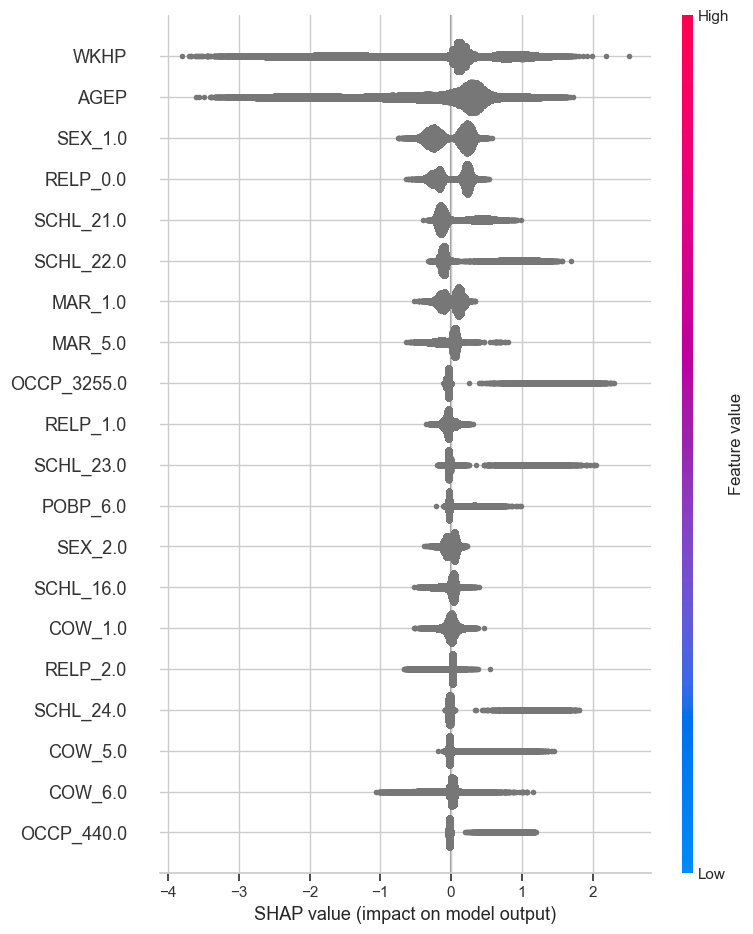

In [ ]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top_20_idx = np.argsort(mean_abs_shap)[-20:][::-1] 
top_20_features = np.array(shap_values.feature_names)[top_20_idx]
 
custom_names = {
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1.0': 'Male',
    'RELP_0.0': 'Householder',
    'SCHL_21.0': 'Bachelors Degree',
    'SCHL_22.0': 'Masters Degree',
    'MAR_1.0': 'Married',
    'MAR_5.0': 'Never Married',
    'OCCP_3255.0': 'Occupation: Registered Nurse',
    'RELP_1.0': 'Husband/Wife of Householder'
}
 
renamed_features = [
    custom_names.get(name, name)
    for name in shap_values.feature_names
]
 
shap_values.feature_names = renamed_features
 
shap.summary_plot(shap_values, X_test_enc, max_display=10)

### T-test code

In [27]:
from scipy.stats import ttest_ind

# example: male v female cauacasian
mask_A = (X_test['SEX'] == 1) & (X_test['RAC1P'] == 1)
mask_B = (X_test['SEX'] == 2) & (X_test['RAC1P'] == 1)

shap_male = shap_values.values[mask_A.values]
shap_female = shap_values.values[mask_B.values]
feature_names =all_feature_names
t_test_results = []

for i, feature in enumerate(feature_names):
    group1 = shap_male[:, i]
    group2 = shap_female[:, i]
    
    stat, pval = ttest_ind(group1, group2, equal_var=False)  # Welch's t-test to account for variance differences
    t_test_results.append({
        'feature': feature,
        't_stat': stat,
        'p_value': pval,
        'mean_diff': group1.mean() - group2.mean()
    })

# Turn into a DataFrame
t_test_df = pd.DataFrame(t_test_results)

# Sort by p-value for significance
t_test_df = t_test_df.sort_values('p_value')

# Display top differences
print(t_test_df[['feature', 't_stat', 'p_value', 'mean_diff']].head(15))


KeyError: 'p_value'

### **Simple FFNN** - Hyperparameter tuning with random grid search


In [30]:
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model


param_dist = {
    'hidden_units': [32, 64, 128],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [1e-2, 1e-3, 1e-4],
    'batch_size': [32, 64],
    'epochs': [10, 20]
}

def sample_params(param_dist):
    return {k: np.random.choice(v) for k, v in param_dist.items()}

n_iter = 10
input_dim = X_train_enc.shape[1]
results = []

cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), cw))



for i in range(n_iter):
    params = sample_params(param_dist)
    print(f"Trial {i+1}/{n_iter} with params: {params}")

    model = build_ffnn(
        input_dim=input_dim,
        hidden_units=params['hidden_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )

    model.fit(
        X_train_enc, y_train,
        validation_data=(X_val_enc, y_val),
        epochs=params['epochs'],
        batch_size=params['batch_size'],
        verbose=0, 
        class_weight=class_weights
        
    )

    val_preds = model.predict(X_val_enc).ravel()
    val_auc = roc_auc_score(y_val, val_preds)
    print(f"Val AUC: {val_auc:.4f}\n")

    results.append((params, val_auc))

# Find the best model
best_params, best_val_auc = max(results, key=lambda x: x[1])
print(f" Best Params: {best_params}\n Best Val AUC: {best_val_auc:.4f}")


Trial 1/10 with params: {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.3), 'learning_rate': np.float64(0.01), 'batch_size': np.int64(64), 'epochs': np.int64(20)}
7803/7803 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Val AUC: 0.8913

Trial 2/10 with params: {'hidden_units': np.int64(64), 'dropout_rate': np.float64(0.3), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(32), 'epochs': np.int64(20)}
7803/7803 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step
Val AUC: 0.8960

Trial 3/10 with params: {'hidden_units': np.int64(64), 'dropout_rate': np.float64(0.2), 'learning_rate': np.float64(0.001), 'batch_size': np.int64(64), 'epochs': np.int64(20)}


KeyboardInterrupt: 

In [9]:
best_params = {'hidden_units': np.int64(128), 'dropout_rate': np.float64(0.3), 'learning_rate': np.float64(0.01), 'batch_size': np.int64(64), 'epochs': np.int64(20)}
n_iter = 10
input_dim = X_train_enc.shape[1]
cw = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(zip(np.unique(y_train), cw))

In [10]:
# build best model
def build_ffnn(input_dim, hidden_units=64, dropout_rate=0.5, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))   # Input layer, preferred way
    model.add(Dense(hidden_units, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(hidden_units // 2, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))  # Binary classification output

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss='binary_crossentropy',
        metrics=['AUC']
    )
    return model

best_model_NN = build_ffnn(
    input_dim=input_dim,
    hidden_units=best_params['hidden_units'],
    dropout_rate=best_params['dropout_rate'],
    learning_rate=best_params['learning_rate']
)

best_model_NN.fit(
    X_train_enc, y_train,
    validation_data=(X_val_enc, y_val),
    epochs=best_params['epochs'],
    batch_size=best_params['batch_size'],
    verbose=0,
    class_weight=class_weights
)


KeyError: 1

In [36]:
model.save('my_model.keras')

### DeepSHAP - will crash your memory

In [30]:

# sample representative background set
background_size = 5000 #10000?

# stratified sample from training set
sss = StratifiedShuffleSplit(n_splits=1, test_size=background_size, random_state=42)
_ , background_idx = next(sss.split(X_train_enc, y_train))

background = X_train_enc[background_idx]
background = background.toarray() if hasattr(background, "toarray") else background

# get test data
X_test_array = X_test_enc.toarray() if hasattr(X_test_enc, "toarray") else X_test_enc

# DeepSHAP

explainer = shap.DeepExplainer(best_model_NN, background)
deep_shap_values = explainer.shap_values(X_test_array)[0]  # [0] for binary output


/Users/linkamitome/anaconda3/lib/python3.11/site-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(


In [32]:
np.save('deep_shap_values.csv', deep_shap_values)

In [21]:
deep_shap_df = pd.DataFrame(deep_shap_values)

In [ ]:
mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
top_20_idx = np.argsort(mean_abs_shap)[-20:][::-1] 
top_20_features = np.array(shap_values.feature_names)[top_20_idx]
 
custom_names = {
    'WKHP': 'Hours worked per week',
    'AGEP': 'Age',
    'SEX_1.0': 'Male',
    'RELP_0.0': 'Householder',
    'SCHL_21.0': 'Bachelors Degree',
    'SCHL_22.0': 'Masters Degree',
    'MAR_1.0': 'Married',
    'MAR_5.0': 'Never Married',
    'OCCP_3255.0': 'Occupation: Registered Nurse',
    'RELP_1.0': 'Husband/Wife of Householder'
}
 
renamed_features = [
    custom_names.get(name, name)
    for name in shap_values.feature_names
]
 
shap_values.feature_names = renamed_features
 
shap.summary_plot(shap_values, X_test_enc, max_display=10)

In [27]:

shap.summary_plot(deep_shap_df, background, max_display=10)

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [23]:
deep_shap_df.shape

(821, 1)

In [25]:
background.T.shape

(821, 5)